In [1]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
from source.datasets.brain_dataset import BrainDataset
from source.loftr.backbone import ResNetFPN_16_4
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from source.loftr.loss import *
from source.visualization.evaluation_visualization import plot_loss_curve
from torch.utils.data import DataLoader
import torch
from einops.einops import rearrange

In [3]:
crop_size = 640
transformation_threshold = 0.15
patch_size = 16
max_translation_shift = 50
fine_feature_size = 160
images_directory = "../../data/cyto_downscaled_3344_3904/"

dataset_test = BrainDataset(
    images_directory=images_directory,
    train=False,
    transformation_threshold=transformation_threshold,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_feature_size=fine_feature_size,
)

dataloader_test = DataLoader(
    dataset=dataset_test,
    batch_size=1,
    shuffle=True,
    pin_memory=False,
    drop_last=True,
)

In [4]:
block_dimensions = [64, 96, 128, 192]
fine_feature_size = block_dimensions[1]
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_16_4(block_dimensions=block_dimensions).cuda()
backbone.load_state_dict(torch.load("../../models/learning_rate0p0008_weight_decay0p001_use_coarse_contextFalse_image_size3344_3904_ResNetResNetFPN_16_4_v1/backbone.pt"))


positional_encoding = PositionalEncoding(coarse_feature_size).cuda()

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
).cuda()
coarse_loftr.load_state_dict(torch.load("../../models/learning_rate0p0008_weight_decay0p001_use_coarse_contextFalse_image_size3344_3904_ResNetResNetFPN_16_4_v1/coarse_loftr.pt"))

coarse_matcher = CoarseMatching(temperature=0.1, confidence_threshold=0.2).cuda()

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=False,
).cuda()

fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
).cuda()
fine_loftr.load_state_dict(torch.load("../../models/learning_rate0p0008_weight_decay0p001_use_coarse_contextFalse_image_size3344_3904_ResNetResNetFPN_16_4_v1/fine_loftr.pt"))


fine_matching = FineMatching().cuda()

params = list(backbone.parameters()) + list(coarse_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=0.001, lr=0.0008)

coarse_loss_history = []
fine_loss_history = []
loss_hist_test = []

In [5]:
backbone.eval()
coarse_loftr.eval()
fine_loftr.eval()

LocalFeatureTransformer(
  (layers): ModuleList(
    (0-1): 2 x LoFTREncoderLayer(
      (q_projection): Linear(in_features=96, out_features=96, bias=False)
      (k_projection): Linear(in_features=96, out_features=96, bias=False)
      (v_projection): Linear(in_features=96, out_features=96, bias=False)
      (attention): LinearAttention()
      (merge): Linear(in_features=96, out_features=96, bias=False)
      (mlp): Sequential(
        (0): Linear(in_features=192, out_features=192, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=192, out_features=96, bias=False)
      )
      (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
  )
)

In [6]:
import numpy as np

confidence_threshold = 0.3
confusion_matrix_total = np.zeros((2, 2))

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
with torch.no_grad():
    for epoch in range(30):
        for (
            image_1_crop,
            image_2_crop,
            match_matrix_ground_truth,
            relative_coordinates,
            _,
        ) in dataloader_test:
            image_1_crop = image_1_crop.cuda()
            image_2_crop = image_2_crop.cuda()
            match_matrix_ground_truth = match_matrix_ground_truth.cuda()
            relative_coordinates = relative_coordinates.cuda()

            coarse_image_feature_1, fine_image_feature_1 = backbone(image_1_crop)
            coarse_image_feature_2, fine_image_feature_2 = backbone(image_2_crop)

            coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
            coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

            coarse_image_feature_1 = rearrange(
                coarse_image_feature_1, "n c h w -> n (h w) c"
            )
            coarse_image_feature_2 = rearrange(
                coarse_image_feature_2, "n c h w -> n (h w) c"
            )

            coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
                coarse_image_feature_1, coarse_image_feature_2
            )

            coarse_matches_predicted = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)
            match_matrix_predicted = coarse_matches_predicted["confidence_matrix"]>confidence_threshold
            confusion_matrix_total += confusion_matrix(match_matrix_ground_truth.cpu().flatten(), match_matrix_predicted.cpu().flatten())

            coarse_matches_ground_truth = {
                "row_indices": match_matrix_ground_truth[0].nonzero()[:, 0],
                "column_indices": match_matrix_ground_truth[0].nonzero()[:, 1],
                "batch_indices": torch.zeros_like(match_matrix_ground_truth[0].nonzero()[:, 0]),
            }

            fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
                coarse_image_feature_1=coarse_image_feature_1,
                coarse_image_feature_2=coarse_image_feature_2,
                fine_image_feature_1=fine_image_feature_1,
                fine_image_feature_2=fine_image_feature_2,
                coarse_matches=coarse_matches_ground_truth,
                fine_height=160,
                coarse_height=40,
            )

            fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(
                fine_image_feature_1_unfold, fine_image_feature_2_unfold
            )

            predicted_relative_coordinates = fine_matching(
                fine_image_feature_1_unfold, fine_image_feature_2_unfold
            )

            coarse_loss_value = coarse_loss(
                predicted_confidence=coarse_matches_predicted["confidence_matrix"],
                ground_truth_confidence=match_matrix_ground_truth,
            )
            fine_loss_value = fine_loss(
                coordinates_predicted=predicted_relative_coordinates,
                coordinates_ground_truth=relative_coordinates,
            )


            coarse_loss_history.append(coarse_loss_value.cpu().item())
            fine_loss_history.append(fine_loss_value.cpu().item())

In [20]:
sum(coarse_loss_history) / len(coarse_loss_history), sum(fine_loss_history) / len(fine_loss_history)

(4.973571848869324, 0.5637151956558227)

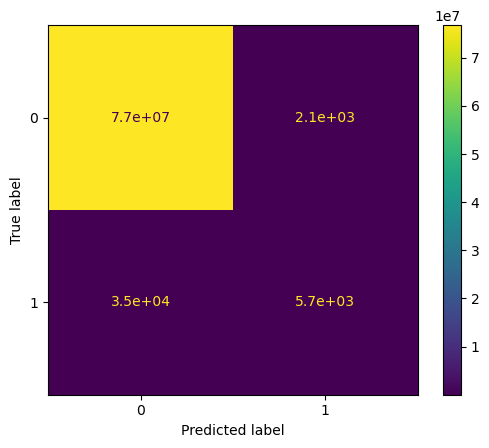

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_total)
disp.plot()

In [10]:
tn, fp, fn, tp = confusion_matrix_total.ravel()

In [11]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print(f"Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}")

Precision: 0.7287335799005229, Recall: 0.14020365599312967, Accuracy: 0.9995160416666666


In [12]:
from source.visualization.image_visualization import plot_images_with_matches_via_match_matrix

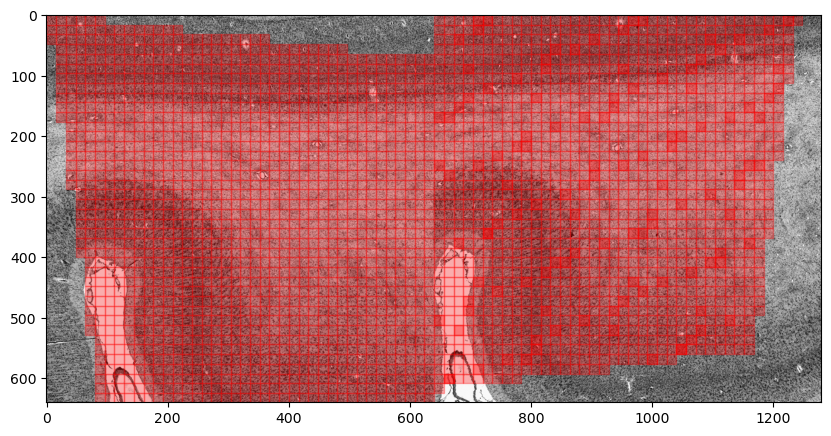

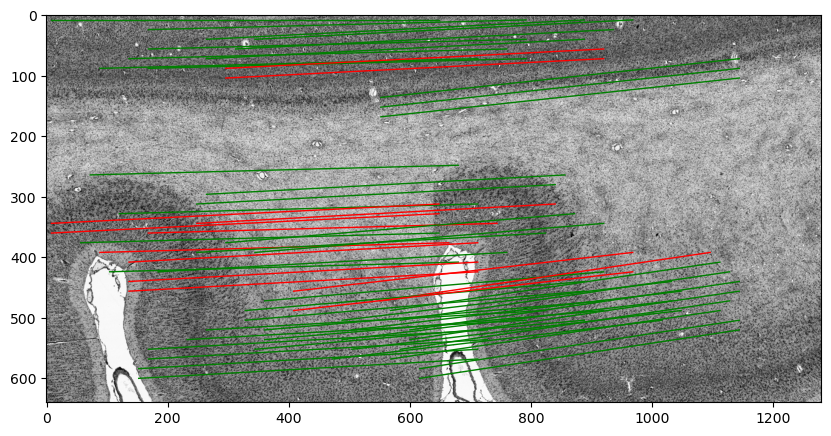

In [13]:
plot_images_with_matches_via_match_matrix(image_1=image_1_crop[0].cpu(), 
                                          image_2=image_2_crop[0].cpu(), 
                                          ground_truth_match_matrix=match_matrix_ground_truth[0].cpu(), 
                                          predicted_match_matrix=None, visualization_mode="patches", line_frequency=50)
plot_images_with_matches_via_match_matrix(image_1=image_1_crop[0].cpu(), 
                                          image_2=image_2_crop[0].cpu(), 
                                          ground_truth_match_matrix=match_matrix_ground_truth[0].cpu(), 
                                          predicted_match_matrix=match_matrix_predicted[0].cpu(), visualization_mode="lines", line_frequency=5)
